In [69]:
import sys
from pathlib import Path
import typing as t
from langgraph.graph import StateGraph, START, END
import textwrap

sys.path.append(str(Path().cwd().parent))

from llm_experiments.models import instantiate_chat

In [70]:
class State(t.TypedDict):
    query: str
    first_answer: str
    is_a_fact: bool
    summarized_answer: str

In [71]:
model = instantiate_chat("4o-mini")

In [72]:
def generate_first_answer(state: State):
    msg = model.invoke(f"answer question: {state['query']}")
    return {"first_answer": msg.content}


def fact_check(state: State):
    msg = model.invoke(f"do a fact check on the following answer: {state['first_answer']}\n. answer only with true or false")
    return {"is_a_fact": msg.content}


def check_if_answer_is_a_fact(state: State):
    if state["is_a_fact"]:
        return "true"
    else:
        return "false"


def summarize_answer(state: State):
    msg = model.invoke(f"summarize the answer: {state['first_answer']}")
    return {"summarized_answer": msg.content}


graph = StateGraph(State)
graph.add_node("generate_first_answer", generate_first_answer)
graph.add_node("fact_check", fact_check)
graph.add_node("summarize_answer", summarize_answer)

graph.add_edge(START, "generate_first_answer")
graph.add_edge("generate_first_answer", "fact_check")
graph.add_conditional_edges("fact_check", check_if_answer_is_a_fact, {"true": "summarize_answer", "false": END})
graph.add_edge("summarize_answer", END)

chain = graph.compile()

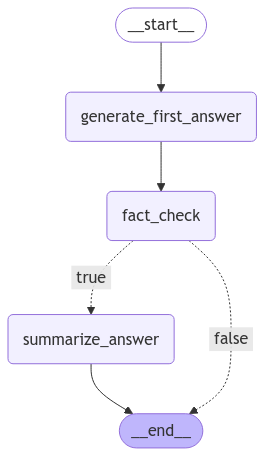

In [73]:
from IPython.display import display
from IPython.display import Image

display(Image(chain.get_graph().draw_mermaid_png()))

In [76]:
for k, v in chain.invoke({"query": "who is the president of the united states?"}).items():
    print(k)
    print(v)
    print()

query
who is the president of the united states?

first_answer
As of my last knowledge update in October 2023, Joe Biden is the President of the United States. He has been in office since January 20, 2021. Please verify with up-to-date sources, as political situations can change.

is_a_fact
True

summarized_answer
Joe Biden is the President of the United States, having taken office on January 20, 2021. Please check current sources for the latest information.



In [77]:
class State(t.TypedDict):
    topic: str
    liberal_opinion: str
    conservative_opinion: str
    compromised_opinion: str

In [78]:
def generate_liberal_opinion(state: State):
    input_text = textwrap.dedent(
        f"""
        you are a partisan of a debate.
        you are given a topic and you need to say a liberal opinion on the topic.
        topic: {state["topic"]}
        """
    )
    msg = model.invoke(input_text)
    return {"liberal_opinion": msg.content}


def generate_conservative_opinion(state: State):
    input_text = textwrap.dedent(
        f"""
        you are a partisan of a debate.
        you are given a topic and you need to say a conservative opinion on the topic.
        topic: {state["topic"]}
        """
    )
    msg = model.invoke(input_text)
    return {"conservative_opinion": msg.content}


def find_a_compromise(state: State):
    input_text = textwrap.dedent(
        f"""
        you are a political analyst.
        you are given two opinions on a topic and you need to find a compromise between the two.
        topic: {state["topic"]}
        liberal opinion: {state["liberal_opinion"]}
        conservative opinion: {state["conservative_opinion"]}
        """
    )
    msg = model.invoke(input_text)
    return {"compromised_opinion": msg.content}


graph = StateGraph(State)
graph.add_node("generate_liberal_opinion", generate_liberal_opinion)
graph.add_node("generate_conservative_opinion", generate_conservative_opinion)
graph.add_node("find_a_compromise", find_a_compromise)

graph.add_edge(START, "generate_liberal_opinion")
graph.add_edge(START, "generate_conservative_opinion")
graph.add_edge("generate_liberal_opinion", "find_a_compromise")
graph.add_edge("generate_conservative_opinion", "find_a_compromise")
graph.add_edge("find_a_compromise", END)

chain = graph.compile()

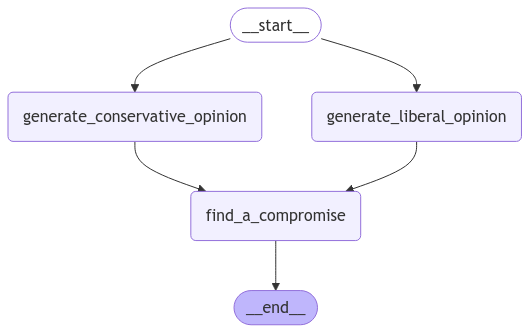

In [79]:
from IPython.display import display

display(Image(chain.get_graph().draw_mermaid_png()))

In [82]:
for k, v in chain.invoke({"topic": "migrants"}).items():
    print(k)
    print(v)
    print()

topic
migrants

liberal_opinion
As a liberal voice in the debate on migrants, I firmly believe that our approach to migration should be rooted in compassion, human rights, and the recognition of the invaluable contributions migrants make to our society. 

First and foremost, it's essential to understand that migrants often leave their home countries due to dire circumstances, including conflict, persecution, and economic hardship. We have a moral obligation to provide refuge and support to those seeking a better life, as it reflects our shared values of empathy and solidarity.

Moreover, migrants play a crucial role in our economy. They fill essential jobs, contribute to innovation, and help sustain the labor force, particularly in industries that rely on migrant labor. By embracing migrants, we are not only supporting individuals and families but also fostering economic growth and vitality in our communities.

In addition, a welcoming stance on migration promotes cultural diversity, e